<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [1]:
# fetch phase 1 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1

In [2]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr

In [3]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase1/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,18.0,0.0,256.0,0.0,0.842499,0.020,0.0,currencyservice-2
1,1647619320,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,18.0,0.0,256.0,0.0,0.819500,0.025,0.0,currencyservice-2
2,1647619380,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,18.0,0.0,256.0,0.0,0.806514,0.020,0.0,currencyservice-2
3,1647619440,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,18.0,0.0,256.0,0.0,0.845354,0.015,0.0,currencyservice-2
4,1647619500,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,18.0,0.0,256.0,0.0,0.804433,0.030,0.0,currencyservice-2


##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset



In [4]:
# describe numerical metrics of train dataset
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,...,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,...,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,...,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,100000.0,0.0,15.000000,0.0,128.000000,0.0,0.049372,0.000000,0.0
25%,1.647641e+09,0.0,102.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,25.000000,100000.0,0.0,21.000000,0.0,224.000000,0.0,0.381905,0.010000,0.0
50%,1.647662e+09,0.0,204.000000,256.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,98.000000,100000.0,0.0,27.000000,0.0,256.000000,0.0,0.939109,0.025000,0.0
75%,1.647684e+09,0.0,204.000000,465.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,174.000000,100000.0,0.0,29.000000,0.0,465.500000,0.0,1.738056,0.055000,0.0
max,1.647706e+09,0.0,409.000000,1025.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,506.000000,100000.0,0.0,41.000000,0.0,1025.000000,0.0,8.847941,0.670000,0.0


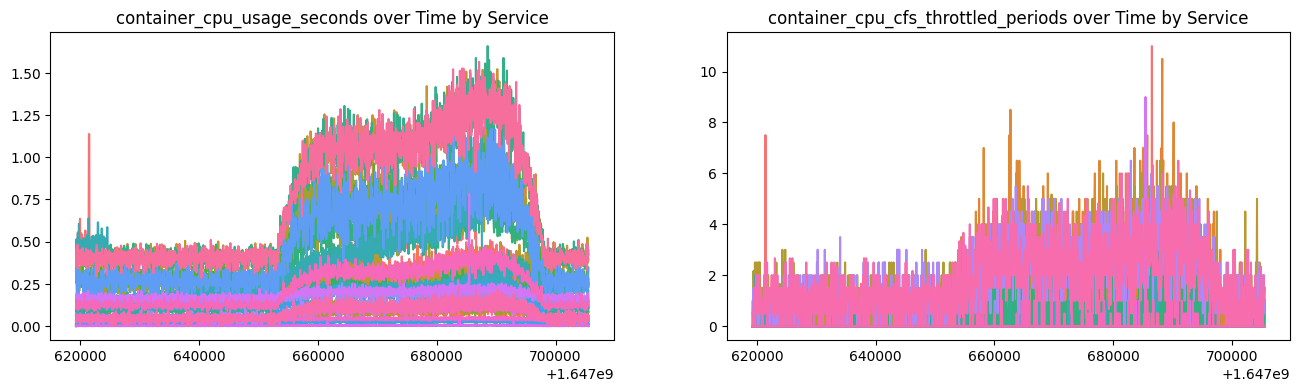

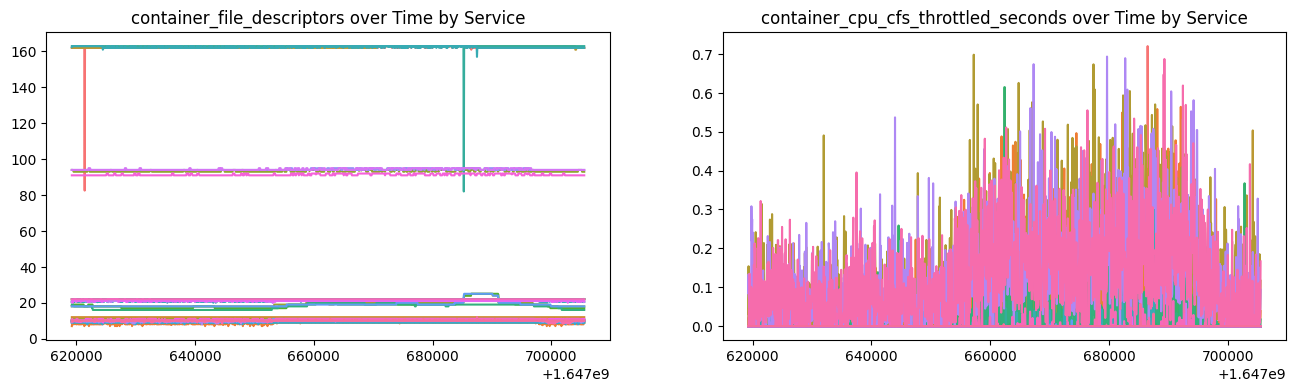

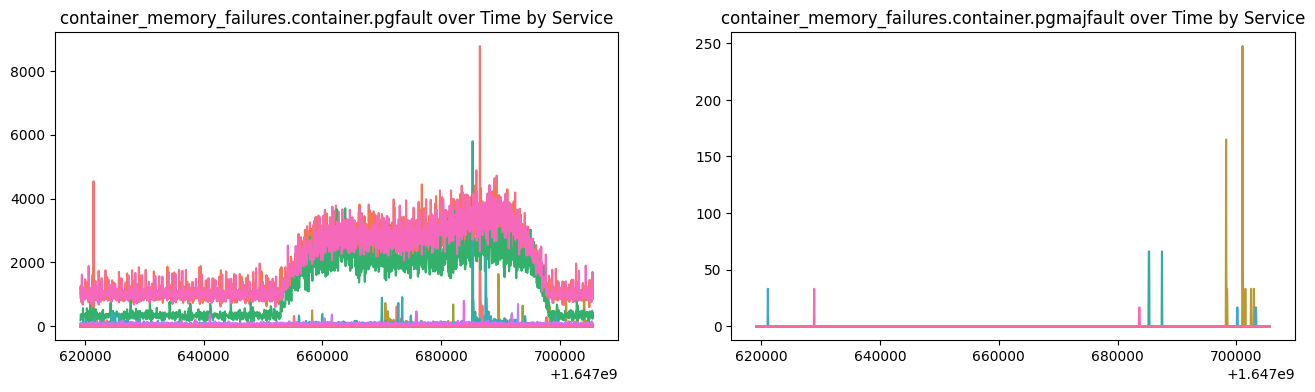

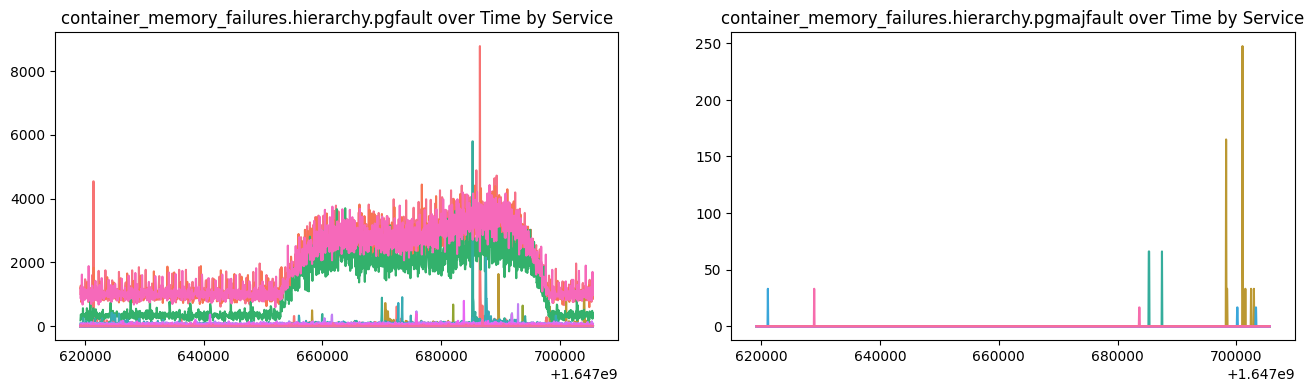

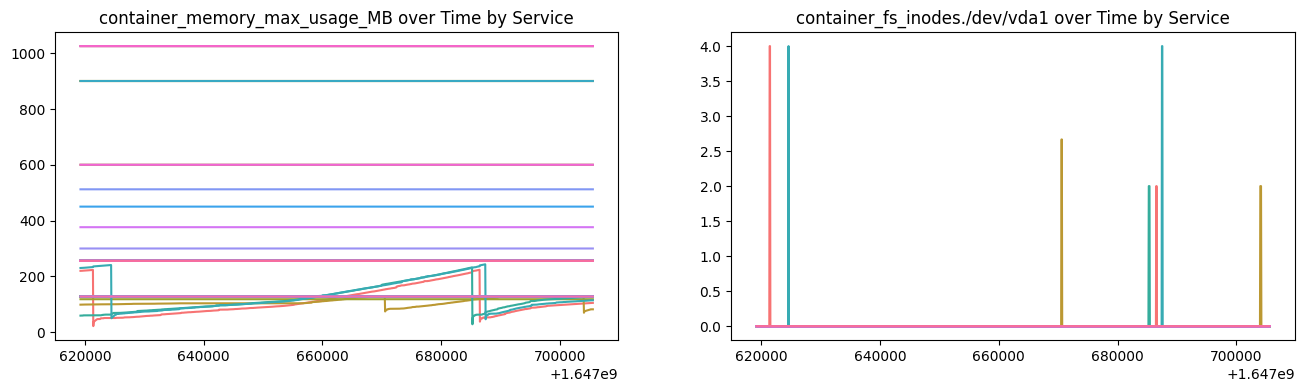

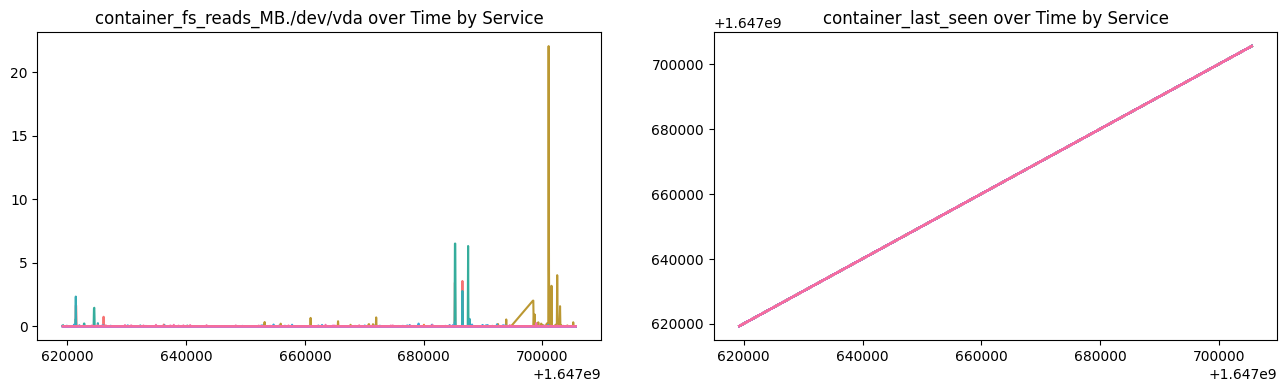

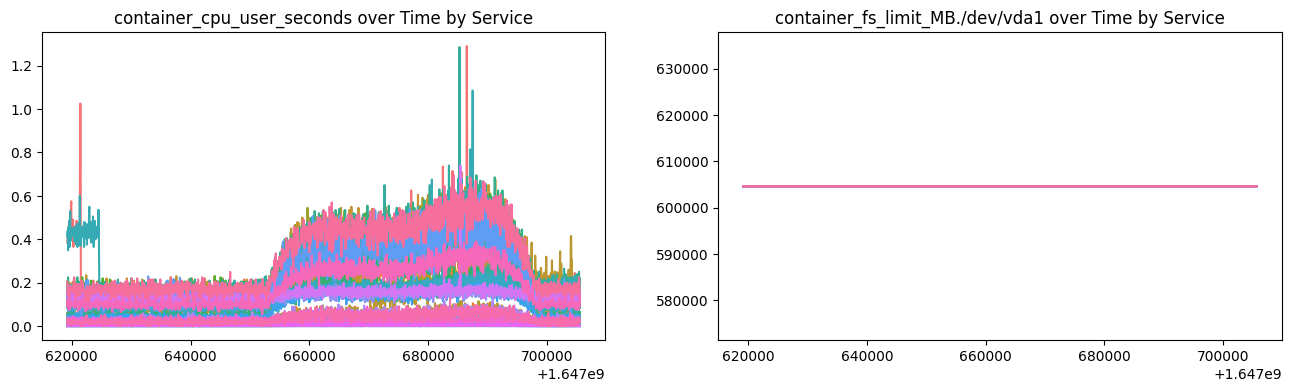

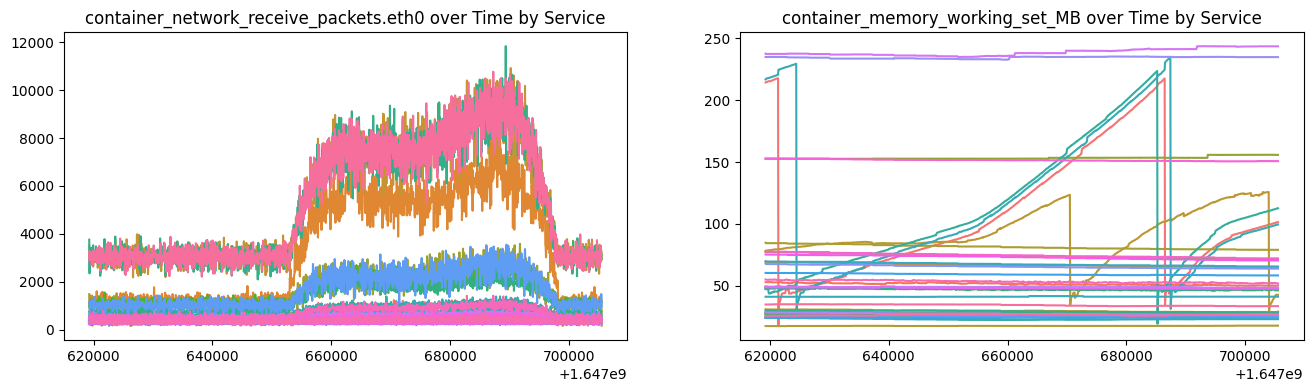

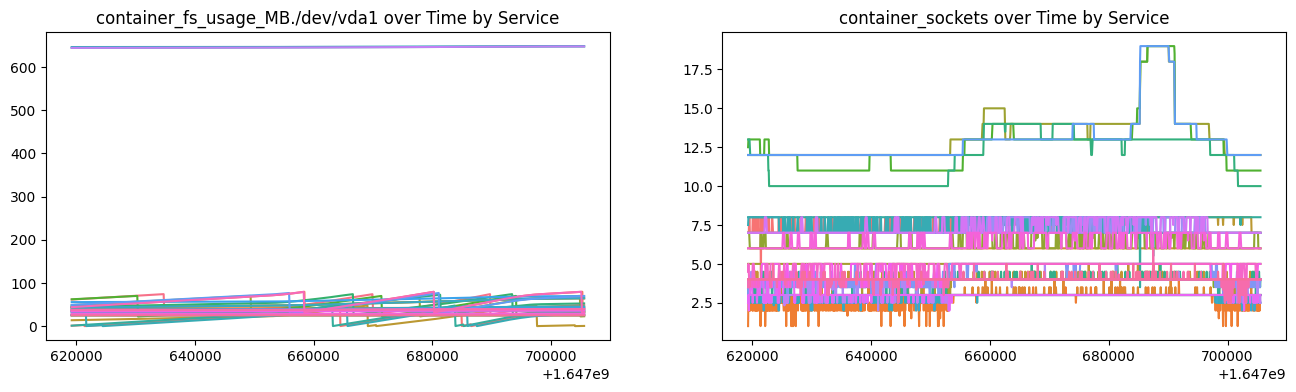

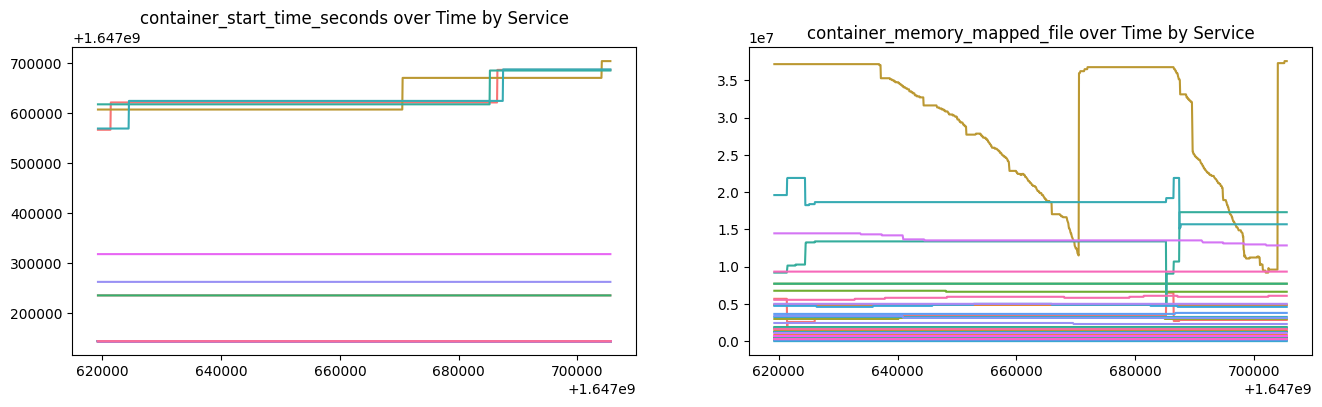

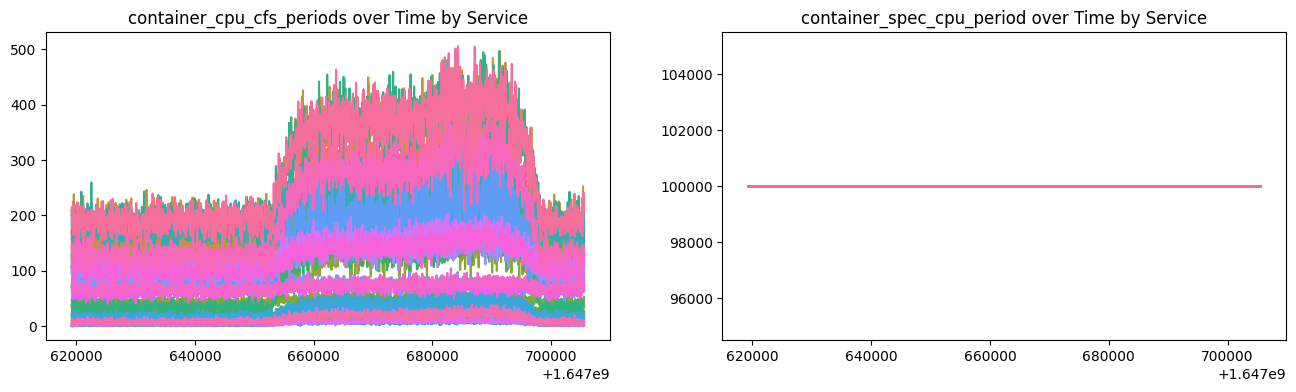

In [5]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices using a LSTM AE. This model will return a series of anomaly scores over time and a boolean which indicates whether the threshold was breached.

If the threshold is breached for one of the services, a root cause analasis starts. In the topology graph, each node will get the value of the maximum anomoly score it had. Each edge will get the value of the pearson corralation between the timeseries of the anomoly scores of the two nodes it connects. The nodes of this graph will be ranked using PageRank.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns.

In [ ]:
class DataManager:
    def __init__(self, 
                 data_path: str,
                 ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns

        # Load from file
        self.data: Dict[str, np.ndarray] = {}
        self.columns: List[str] = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            self.data[file[:-4]] = cur_df[self.columns].values

    def get(self, s: str) -> np.ndarray:
        return self.data[s]

###3.2 Anomaly detection

The anomaly detection model uses two classes:
- $LSTMAEDetector$ holds a LSTM AE to detect anomolies in a microservice. Before fitting the model, it first prepares the input data by scaling and creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled so all microservices can use the same threshold. To make a prediction, the data is prepared the same way and the scaled reconstruction loss of the model is calculated. This will be the anomaly score. All the anomaly scores will be returned and it will also check whether the threshold was breached at any point.

- The anomaly detector class will create and fit the LSTM AE Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return whether they encountered an anomoly and their anomoly scores.





In [ ]:
# creates sequences of the data
def to_sequences(x, seq_size=1):
    x_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x[i:(i+seq_size)])

    return np.array(x_values)


class LSTMAEDetector:
    def __init__(self):
        self.model = Sequential()
        self.threshold = 0.9
        self.input_scaler = []
        self.loss_scaler = MinMaxScaler()

    def fit(self, data: np.ndarray):
        for i in range(data.shape[1]):
            scaler = MinMaxScaler()
            scaler = scaler.fit(data[:, i])
            self.input_scaler.append(scaler)

            data[:, i] = scaler.transform(data[:, i])

        train_x = to_sequences(data, 10)

        self.model.add(LSTM(128, input_shape=(train_x.shape[1], train_x.shape[2])))
        self.model.add(Dropout(rate=0.2))
        self.model.add(RepeatVector(train_x.shape[1]))
        self.model.add(LSTM(128, return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(TimeDistributed(Dense(train_x.shape[2])))
        self.model.compile(optimizer='adam', loss='mae')

        self.model.fit(train_x, train_x, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

        predict = self.model.predict(train_x)
        loss = np.mean(np.abs(predict - train_x), axis=1)
        self.loss_scaler.fit(loss)

    def set_threshold(self, threshold):
        self.threshold = threshold

    def decision_function(self, data: np.ndarray):
        for i in range(data.shape[1]):
            data[:, i] = self.input_scaler[i].transform(data[:, i])

        test_x, = to_sequences(data, 10)

        predict = self.model.predict(test_x)
        loss = self.loss_scaler.transform(np.mean(np.abs(predict - test_x), axis=1))
        anomalies = np.any(np.greater(predict, self.threshold))
        return loss, anomalies


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, LSTMAEDetector] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = LSTMAEDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            scores, anomaly = self.detector_dict[k].decision_function(v)

            assert type(scores) == np.ndarray
            anomaly_scores[k] = scores

        return anomalies, anomaly_scores

###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. Initializing the Ranker will also initialize the anomaly detector. To start ranking the microservices their anomaly scores are calculated. If there is an anomaly then the algorithm will use following scoring formula to perform a simplified version of pagerank:

$$v_{t+1} = (1 - c)Pv_t + cu$$

where $P$ is a matrix holding the weights of all edges and $u$ is a vector with for each microservice the max anomaly score. For all edges in the topology, $P$ is equal to the pearson correlation of the nodes it connects and 0 for all other edges. This means that the score for the nodes $v$ is parially defined by the anomaly score of the microservice and partially by the score of their parent nodes but that depends on the corralation between their anomaly scores.

This algrorithm is based on the MicroRCA algorithm, but we do not have all the data they had.

Li Wu, Johan Tordsson, Erik Elmroth, Odej Kao. MicroRCA: Root Cause Localization of Performance
Issues in Microservices. IEEE/IFIP Network Operations and Management Symposium (NOMS), Apr
2020, Budapest, Hungary. ffhal-02441640f

https://inria.hal.science/hal-02441640

In [ ]:
class Ranker:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params

        self.train_data = DataManager(hyper_params['train_dir'])
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):     
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomalies, anomaly_score = self.anomaly_detector.detect(test_data)

        # If no anomalies where detected return None
        if not any(a for a in anomalies.values()):
            return None

        # Find P and u for pagerank
        services = list(anomaly_score.keys())
        P = np.zeros(len(services), len(services))
        u = np.zeros(len(services), 1)

        with open(self.hyper_params['topology'], 'rt') as f:
            topology = json.load(f)

        for i, service in enumerate(services):
            u[i][0] = np.max(anomaly_score[service])
            for key, values in topology.items():
                if service.startswith(key):
                    for value in values:
                        for j, s in enumerate(services):
                            if s.startswith(value):
                                P[i][j] = pearsonr(anomaly_score[service], anomaly_score[s])

        v = u.copy()
        c = 0.55

        for i in range(10):
            v = (1-c)*np.matmul(P, v) + c*u

        # Rank services based on their page rank score
        scores = {services[i]: v[i][0] for i in range(len(services))}

        rank_result = sorted(list(scores.keys()), key=lambda x: scores[x], reverse=True)

        return rank_result

##4. evaluation, prediction and metrics

- evaluate test set predictions
- define KPIs and relevant metrics
- create info-dashboard explaining the findings

In [ ]:
#test datasets will need to be tested in loop via anomaly detection model
#label.json will be use in every loop by index to verify the prediction
#code in src folder can be used as initial template (?)